In [1]:
import tensorflow as tf
tf.keras.__version__

'2.2.4-tf'

# Classifying movie reviews: a binary classification example

This notebook contains the code samples found in Chapter 3, Section 5 of [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). Note that the original text features far more content, in particular further explanations and figures: in this notebook, you will only find source code and related comments.

----


Two-class classification, or binary classification, may be the most widely applied kind of machine learning problem. In this example, we 
will learn to classify movie reviews into "positive" reviews and "negative" reviews, just based on the text content of the reviews.

## The IMDB dataset


We'll be working with "IMDB dataset", a set of 50,000 highly-polarized reviews from the Internet Movie Database. They are split into 25,000 
reviews for training and 25,000 reviews for testing, each set consisting in 50% negative and 50% positive reviews.

Why do we have these two separate training and test sets? You should never test a machine learning model on the same data that you used to 
train it! Just because a model performs well on its training data doesn't mean that it will perform well on data it has never seen, and 
what you actually care about is your model's performance on new data (since you already know the labels of your training data -- obviously 
you don't need your model to predict those). For instance, it is possible that your model could end up merely _memorizing_ a mapping between 
your training samples and their targets -- which would be completely useless for the task of predicting targets for data never seen before. 
We will go over this point in much more detail in the next chapter.

Just like the MNIST dataset, the IMDB dataset comes packaged with Keras. It has already been preprocessed: the reviews (sequences of words) 
have been turned into sequences of integers, where each integer stands for a specific word in a dictionary.

The following code will load the dataset (when you run it for the first time, about 80MB of data will be downloaded to your machine):

In [2]:
#from keras.datasets import imdb

(train_data, train_labels), (test_data, test_labels) = tf.keras.datasets.imdb.load_data(num_words=10000)


The argument `num_words=10000` means that we will only keep the top 10,000 most frequently occurring words in the training data. Rare words 
will be discarded. This allows us to work with vector data of manageable size.

The variables `train_data` and `test_data` are lists of reviews, each review being a list of word indices (encoding a sequence of words). 
`train_labels` and `test_labels` are lists of 0s and 1s, where 0 stands for "negative" and 1 stands for "positive":

In [3]:
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [4]:
train_labels[0]

1

Since we restricted ourselves to the top 10,000 most frequent words, no word index will exceed 10,000:

In [5]:
max([max(sequence) for sequence in train_data])

9999

For kicks, here's how you can quickly decode one of these reviews back to English words:

In [6]:
imdb = tf.keras.datasets.imdb
# word_index is a dictionary mapping words to an integer index
word_index = imdb.get_word_index()
# We reverse it, mapping integer indices to words
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# We decode the review; note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_review = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [7]:
decoded_review

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

## Preparing the data


We cannot feed lists of integers into a neural network. We have to turn our lists into tensors. There are two ways we could do that:

* We could pad our lists so that they all have the same length, and turn them into an integer tensor of shape `(samples, word_indices)`, 
then use as first layer in our network a layer capable of handling such integer tensors (the `Embedding` layer, which we will cover in 
detail later in the book).
* We could one-hot-encode our lists to turn them into vectors of 0s and 1s. Concretely, this would mean for instance turning the sequence 
`[3, 5]` into a 10,000-dimensional vector that would be all-zeros except for indices 3 and 5, which would be ones. Then we could use as 
first layer in our network a `Dense` layer, capable of handling floating point vector data.

We will go with the latter solution. Let's vectorize our data, which we will do manually for maximum clarity:

In [8]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)

Here's what our samples look like now:

In [9]:
count_0 = 0
count_1 = 0

for i in x_train[0]:
    if i == 0:
        count_0 += 1
    elif i == 1:
        count_1 += 1
        
count_0, count_1

(9880, 120)

We should also vectorize our labels, which is straightforward:

In [10]:
# Our vectorized labels
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

Now our data is ready to be fed into a neural network.

## Building our network


Our input data is simply vectors, and our labels are scalars (1s and 0s): this is the easiest setup you will ever encounter. A type of 
network that performs well on such a problem would be a simple stack of fully-connected (`Dense`) layers with `relu` activations: `Dense(16, 
activation='relu')`

The argument being passed to each `Dense` layer (16) is the number of "hidden units" of the layer. What's a hidden unit? It's a dimension 
in the representation space of the layer. You may remember from the previous chapter that each such `Dense` layer with a `relu` activation implements 
the following chain of tensor operations:

`output = relu(dot(W, input) + b)`

Having 16 hidden units means that the weight matrix `W` will have shape `(input_dimension, 16)`, i.e. the dot product with `W` will project the 
input data onto a 16-dimensional representation space (and then we would add the bias vector `b` and apply the `relu` operation). You can 
intuitively understand the dimensionality of your representation space as "how much freedom you are allowing the network to have when 
learning internal representations". Having more hidden units (a higher-dimensional representation space) allows your network to learn more 
complex representations, but it makes your network more computationally expensive and may lead to learning unwanted patterns (patterns that 
will improve performance on the training data but not on the test data).

There are two key architecture decisions to be made about such stack of dense layers:

* How many layers to use.
* How many "hidden units" to chose for each layer.

In the next chapter, you will learn formal principles to guide you in making these choices. 
For the time being, you will have to trust us with the following architecture choice: 
two intermediate layers with 16 hidden units each, 
and a third layer which will output the scalar prediction regarding the sentiment of the current review. 
The intermediate layers will use `relu` as their "activation function", 
and the final layer will use a sigmoid activation so as to output a probability 
(a score between 0 and 1, indicating how likely the sample is to have the target "1", i.e. how likely the review is to be positive). 
A `relu` (rectified linear unit) is a function meant to zero-out negative values, 
while a sigmoid "squashes" arbitrary values into the `[0, 1]` interval, thus outputting something that can be interpreted as a probability.

Here's what our network looks like:

![3-layer network](https://s3.amazonaws.com/book.keras.io/img/ch3/3_layer_network.png)

And here's the Keras implementation, very similar to the MNIST example you saw previously:

In [11]:
models = tf.keras.models
layers = tf.keras.layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [13]:
?layers.Dense


Lastly, we need to pick a loss function and an optimizer. Since we are facing a binary classification problem and the output of our network 
is a probability (we end our network with a single-unit layer with a sigmoid activation), is it best to use the `binary_crossentropy` loss. 
It isn't the only viable choice: you could use, for instance, `mean_squared_error`. But crossentropy is usually the best choice when you 
are dealing with models that output probabilities. Crossentropy is a quantity from the field of Information Theory, that measures the "distance" 
between probability distributions, or in our case, between the ground-truth distribution and our predictions.

Here's the step where we configure our model with the `rmsprop` optimizer and the `binary_crossentropy` loss function. Note that we will 
also monitor accuracy during training.

In [22]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

We are passing our optimizer, loss function and metrics as strings, which is possible because `rmsprop`, `binary_crossentropy` and 
`accuracy` are packaged as part of Keras. Sometimes you may want to configure the parameters of your optimizer, or pass a custom loss 
function or metric function. This former can be done by passing an optimizer class instance as the `optimizer` argument:

In [23]:
optimizers = tf.keras.optimizers

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

The latter can be done by passing function objects as the `loss` or `metrics` arguments:

In [24]:
losses = tf.keras.losses
metrics = tf.keras.metrics

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.binary_crossentropy,
              metrics=[metrics.binary_accuracy])

## Validating our approach

In order to monitor during training the accuracy of the model on data that it has never seen before, we will create a "validation set" by 
setting apart 10,000 samples from the original training data:

In [25]:
x_val = x_train[:10000]
partial_x_train = x_train[10000:]

y_val = y_train[:10000]
partial_y_train = y_train[10000:]

We will now train our model for 20 epochs (20 iterations over all samples in the `x_train` and `y_train` tensors), in mini-batches of 512 
samples. At this same time we will monitor loss and accuracy on the 10,000 samples that we set apart. This is done by passing the 
validation data as the `validation_data` argument:

In [26]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

W0620 20:55:11.633105 139871821047616 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 127us/sample - loss: 0.5226 - binary_accuracy: 0.7694 - val_loss: 0.3969 - val_binary_accuracy: 0.8605
Epoch 2/20
15000/15000 [==============================] - 1s 96us/sample - loss: 0.3144 - binary_accuracy: 0.9025 - val_loss: 0.3121 - val_binary_accuracy: 0.8845
Epoch 3/20
15000/15000 [==============================] - 1s 95us/sample - loss: 0.2286 - binary_accuracy: 0.9273 - val_loss: 0.2804 - val_binary_accuracy: 0.8913
Epoch 4/20
15000/15000 [==============================] - 1s 96us/sample - loss: 0.1829 - binary_accuracy: 0.9414 - val_loss: 0.2776 - val_binary_accuracy: 0.8897
Epoch 5/20
15000/15000 [==============================] - 1s 95us/sample - loss: 0.1455 - binary_accuracy: 0.9546 - val_loss: 0.2797 - val_binary_accuracy: 0.8886
Epoch 6/20
15000/15000 [==============================] - 1s 96us/sample - loss: 0.1222 - binary_accuracy: 0.9635 - val_loss: 0.2904 -

On CPU, this will take less than two seconds per epoch -- training is over in 20 seconds. At the end of every epoch, there is a slight pause 
as the model computes its loss and accuracy on the 10,000 samples of the validation data.

Note that the call to `model.fit()` returns a `History` object. This object has a member `history`, which is a dictionary containing data 
about everything that happened during training. Let's take a look at it:

In [27]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

It contains 4 entries: one per metric that was being monitored, during training and during validation. Let's use Matplotlib to plot the 
training and validation loss side by side, as well as the training and validation accuracy:

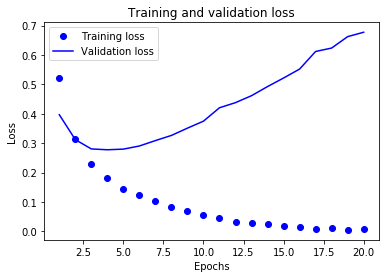

In [29]:
import matplotlib.pyplot as plt

acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

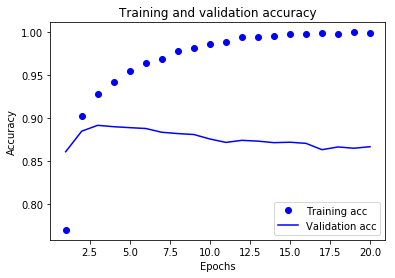

In [31]:
plt.clf()   # clear figure
acc_values = history_dict['binary_accuracy']
val_acc_values = history_dict['val_binary_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


The dots are the training loss and accuracy, while the solid lines are the validation loss and accuracy. Note that your own results may vary 
slightly due to a different random initialization of your network.

As you can see, the training loss decreases with every epoch and the training accuracy increases with every epoch. That's what you would 
expect when running gradient descent optimization -- the quantity you are trying to minimize should get lower with every iteration. But that 
isn't the case for the validation loss and accuracy: they seem to peak at the fourth epoch. This is an example of what we were warning 
against earlier: a model that performs better on the training data isn't necessarily a model that will do better on data it has never seen 
before. In precise terms, what you are seeing is "overfitting": after the second epoch, we are over-optimizing on the training data, and we 
ended up learning representations that are specific to the training data and do not generalize to data outside of the training set.

In this case, to prevent overfitting, we could simply stop training after three epochs. In general, there is a range of techniques you can 
leverage to mitigate overfitting, which we will cover in the next chapter.

Let's train a new network from scratch for four epochs, then evaluate it on our test data:

In [32]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=4, batch_size=512)
results = model.evaluate(x_test, y_test)

Train on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 2s 68us/sample - loss: 0.4584 - accuracy: 0.8212
Epoch 2/4
25000/25000 [==============================] - 1s 60us/sample - loss: 0.2627 - accuracy: 0.9095
Epoch 3/4
25000/25000 [==============================] - 1s 58us/sample - loss: 0.2027 - accuracy: 0.9272
Epoch 4/4
25000/25000 [==============================] - 1s 57us/sample - loss: 0.2891 - accuracy: 0.8848


In [33]:
results

[0.2891393591499329, 0.88484]

Our fairly naive approach achieves an accuracy of 88%. With state-of-the-art approaches, one should be able to get close to 95%.

## Using a trained network to generate predictions on new data

After having trained a network, you will want to use it in a practical setting. You can generate the likelihood of reviews being positive 
by using the `predict` method:

In [34]:
model.predict(x_test)

array([[0.21653834],
       [0.99962914],
       [0.9399378 ],
       ...,
       [0.13239095],
       [0.07486576],
       [0.5509254 ]], dtype=float32)

As you can see, the network is very confident for some samples (0.99 or more, or 0.01 or less) but less confident for others (0.6, 0.4). 


## Further experiments


* We were using 2 hidden layers. Try to use 1 or 3 hidden layers and see how it affects validation and test accuracy.
* Try to use layers with more hidden units or less hidden units: 32 units, 64 units...
* Try to use the `mse` loss function instead of `binary_crossentropy`.
* Try to use the `tanh` activation (an activation that was popular in the early days of neural networks) instead of `relu`.

These experiments will help convince you that the architecture choices we have made are all fairly reasonable, although they can still be 
improved!

## Conclusions


Here's what you should take away from this example:

* There's usually quite a bit of preprocessing you need to do on your raw data in order to be able to feed it -- as tensors -- into a neural 
network. In the case of sequences of words, they can be encoded as binary vectors -- but there are other encoding options too.
* Stacks of `Dense` layers with `relu` activations can solve a wide range of problems (including sentiment classification), and you will 
likely use them frequently.
* In a binary classification problem (two output classes), your network should end with a `Dense` layer with 1 unit and a `sigmoid` activation, 
i.e. the output of your network should be a scalar between 0 and 1, encoding a probability.
* With such a scalar sigmoid output, on a binary classification problem, the loss function you should use is `binary_crossentropy`.
* The `rmsprop` optimizer is generally a good enough choice of optimizer, whatever your problem. That's one less thing for you to worry 
about.
* As they get better on their training data, neural networks eventually start _overfitting_ and end up obtaining increasingly worse results on data 
never-seen-before. Make sure to always monitor performance on data that is outside of the training set.
